一個模型服務一個風格(Per-Style-Per-Model:PSPM)
=============================
作者 : 湯沂達 https://github.com/mistake0316

-------------

簡介
------------
在上一個版本的程式碼我們復現了論文 `A Neural Algorithm of Artistic Style
 <https://arxiv.org/abs/1508.06576>`。

<img src="https://imgur.com/L119232.jpg" width="800px"/><br>
上一版本的程式碼是找一張影像，使得損失函數最小，如上圖所示。<br>
<img src="https://imgur.com/R11Jjho.jpg" width="800px"/><br>
而這次的記事本是要復現這個論文`Perceptual Losses for Real-Time Style Transfer and Super-Resolution<https://arxiv.org/abs/1603.08155>`<br>
主要方法是要找到一個模型，使得內容影像輸入模型後得到的的新影像的同一個損失函數越小越好。<br>




<h2>與上一份程式碼不同處 **</h2>
原本是對**`影像`**做梯度下降，此處改為對**`模型`**做梯度下降
> 註：由於要訓練能服務任意輸入的影像會需要比較久的訓練時間<br>
此處為了演示方便，並沒有放入訓練的程式碼，直接使用pytorch官方範例的預訓練模型

* pytorch example github [link](https://github.com/pytorch/examples)
* fast neural style [link](https://github.com/pytorch/examples/tree/main/fast_neural_style)

In [ ]:
#@title 導入函式庫
!pip -q install torchinfo
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import plotly.express as px

import torchvision.transforms as transforms
import torchvision.models as models
import torchvision

import torchinfo

from tqdm.auto import tqdm
from collections import OrderedDict
import numpy as np

import copy
import re
import os

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device:{device}")

device:cuda


In [ ]:
#@title 下載影像
!rm -rf Neural-Style-Transfer
!git clone https://github.com/titu1994/Neural-Style-Transfer
!mv ./Neural-Style-Transfer/images/inputs ./images
!rm -rf Neural-Style-Transfer

Cloning into 'Neural-Style-Transfer'...
remote: Enumerating objects: 1421, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 1421 (delta 8), reused 12 (delta 4), pack-reused 1393
Receiving objects: 100% (1421/1421), 68.19 MiB | 23.01 MiB/s, done.
Resolving deltas: 100% (827/827), done.
mv: cannot move './Neural-Style-Transfer/images/inputs' to './images/inputs': Directory not empty


In [ ]:
#@title 下載預訓練模型 & 對應影像
# [原程式碼](https://github.com/pytorch/examples/blob/main/fast_neural_style/download_saved_models.py#L27)
%%bash
wget --quiet https://www.dropbox.com/s/lrvwfehqdcxoza8/saved_models.zip?dl=1 -O saved_models.zip
unzip -o saved_models.zip

folder=torch_example_style
mkdir -p $folder
for img_name in {candy,mosaic,rain-princess-cropped,rain-princess,udnie}
do
  wget -q https://raw.githubusercontent.com/pytorch/examples/main/fast_neural_style/images/style-images/${img_name}.jpg -O $folder/$img_name.jpg
done

Archive:  saved_models.zip
  inflating: saved_models/candy.pth  
  inflating: saved_models/mosaic.pth  
  inflating: saved_models/rain_princess.pth  
  inflating: saved_models/udnie.pth  


In [ ]:
content_paths = os.listdir("images/content")
content_paths

['golden_gate.jpg',
 'Dipping-Sun.jpg',
 'Sunlit Mountains.jpg',
 'Aurea-Luna.jpg',
 'Japanese-cherry-widescreen-wallpaper-Picture-1366x768.jpg',
 'Dawn Sky.jpg',
 'Kinkaku-ji.jpg',
 'winter-wolf.jpg',
 'sagano_bamboo_forest.jpg',
 'blue-moon-lake.jpg',
 'ancient_city.jpg',
 'tubingen.jpg']

In [ ]:
#@title available models
model_names_option = os.listdir("saved_models")
print(model_names_option, sep="\n")

['rain_princess.pth', 'udnie.pth', 'mosaic.pth', 'candy.pth']


In [ ]:
# desired size of the output image
imsize = 512 #@param {type:"number"}

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()])


def image_loader(image_name, mod=64):
    image = Image.open(image_name)
    image = loader(image)
    image = image[:,:image.shape[1]//mod*mod, :image.shape[2]//mod*mod].unsqueeze(0)
    return image.to(device, torch.float)

content_path = "./images/content/Kinkaku-ji.jpg" #@param {type:"string"}
style_model_name = "rain_princess" #@param ['rain_princess', 'udnie', 'mosaic', 'candy']

style_img_path = f"./torch_example_style/{style_model_name.replace('_','-')}.jpg"
style_model_path = f"./saved_models/{style_model_name}.pth"

content_img = image_loader(content_path)
style_img = image_loader(
    style_img_path
)


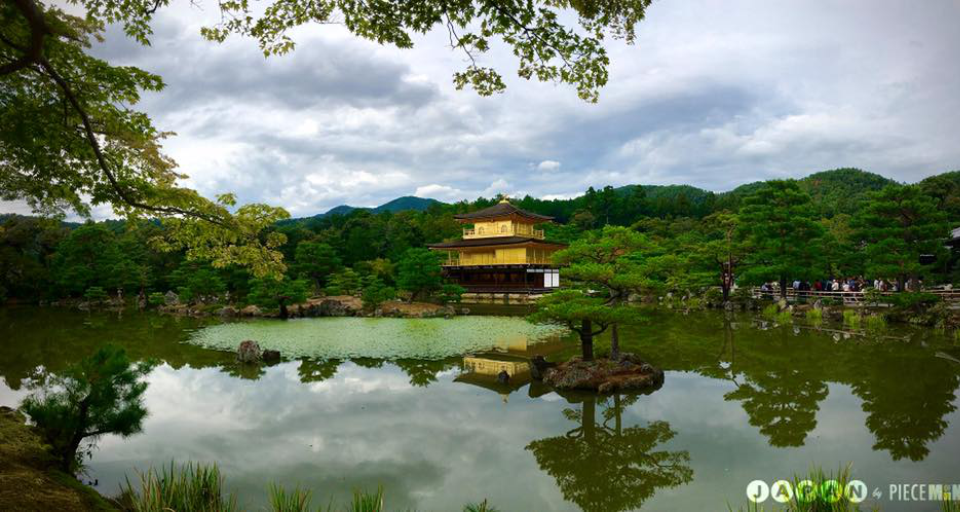


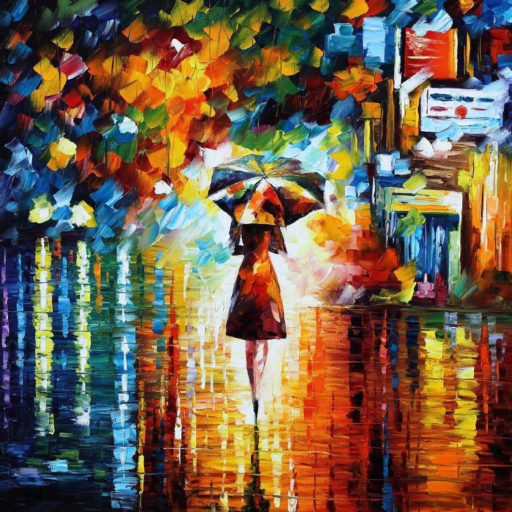

In [ ]:
unloader = transforms.ToPILImage()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    px.imshow(image, title=title).show()
    
imshow(content_img, title='Content Image')
imshow(style_img, title='Style Image')

## 風格轉換模型
Source Code : https://github.com/pytorch/examples/blob/main/fast_neural_style/neural_style/transformer_net.py


### Whole model

In [ ]:
class TransformerNet(torch.nn.Module):
    def __init__(self):
        super(TransformerNet, self).__init__()
        # Initial convolution layers
        self.conv1 = ConvLayer(3, 32, kernel_size=9, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(32, affine=True)
        self.conv2 = ConvLayer(32, 64, kernel_size=3, stride=2)
        self.in2 = torch.nn.InstanceNorm2d(64, affine=True)
        self.conv3 = ConvLayer(64, 128, kernel_size=3, stride=2)
        self.in3 = torch.nn.InstanceNorm2d(128, affine=True)
        # Residual layers
        self.res1 = ResidualBlock(128)
        self.res2 = ResidualBlock(128)
        self.res3 = ResidualBlock(128)
        self.res4 = ResidualBlock(128)
        self.res5 = ResidualBlock(128)
        # Upsampling Layers
        self.deconv1 = UpsampleConvLayer(128, 64, kernel_size=3, stride=1, upsample=2)
        self.in4 = torch.nn.InstanceNorm2d(64, affine=True)
        self.deconv2 = UpsampleConvLayer(64, 32, kernel_size=3, stride=1, upsample=2)
        self.in5 = torch.nn.InstanceNorm2d(32, affine=True)
        self.deconv3 = ConvLayer(32, 3, kernel_size=9, stride=1)
        # Non-linearities
        self.relu = torch.nn.ReLU()

    def forward(self, X):
        y = self.relu(self.in1(self.conv1(X)))
        y = self.relu(self.in2(self.conv2(y)))
        y = self.relu(self.in3(self.conv3(y)))
        y = self.res1(y)
        y = self.res2(y)
        y = self.res3(y)
        y = self.res4(y)
        y = self.res5(y)
        y = self.relu(self.in4(self.deconv1(y)))
        y = self.relu(self.in5(self.deconv2(y)))
        y = self.deconv3(y)
        return y

### ConvLayer

In [ ]:
class ConvLayer(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride):
        super(ConvLayer, self).__init__()
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        out = self.reflection_pad(x)
        out = self.conv2d(out)
        return out

### ResidualBlock

In [ ]:
class ResidualBlock(torch.nn.Module):
    """ResidualBlock
    introduced in: https://arxiv.org/abs/1512.03385
    recommended architecture: http://torch.ch/blog/2016/02/04/resnets.html
    """

    def __init__(self, channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in1 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.conv2 = ConvLayer(channels, channels, kernel_size=3, stride=1)
        self.in2 = torch.nn.InstanceNorm2d(channels, affine=True)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.relu(self.in1(self.conv1(x)))
        out = self.in2(self.conv2(out))
        out = out + residual
        return out

### UpsampleConvLayer

In [ ]:
class UpsampleConvLayer(torch.nn.Module):
    """UpsampleConvLayer
    Upsamples the input and then does a convolution. This method gives better results
    compared to ConvTranspose2d.
    ref: http://distill.pub/2016/deconv-checkerboard/
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride, upsample=None):
        super(UpsampleConvLayer, self).__init__()
        self.upsample = upsample
        reflection_padding = kernel_size // 2
        self.reflection_pad = torch.nn.ReflectionPad2d(reflection_padding)
        self.conv2d = torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride)

    def forward(self, x):
        x_in = x
        if self.upsample:
            x_in = torch.nn.functional.interpolate(x_in, mode='nearest', scale_factor=self.upsample)
        out = self.reflection_pad(x_in)
        out = self.conv2d(out)
        return out

### Preprocess



In [ ]:
def preprocess(tensor):
    mean = torch.tensor([0.485, 0.456, 0.406],device=tensor.device).view(-1, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225],device=tensor.device).view(-1, 1, 1)
    # tensor = tensor/255.0
    return (tensor-mean)/std

## 開始執行吧！

In [ ]:
style_model = TransformerNet()
def get_state_dict(path):
  state_dict = torch.load(path)
  # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
  for k in list(state_dict.keys()):
      if re.search(r'in\d+\.running_(mean|var)$', k):
          del state_dict[k]
  return state_dict

style_model.load_state_dict(
    get_state_dict(style_model_path)
)
style_model.to(device)
style_model.eval()
print("model loaded")

model loaded



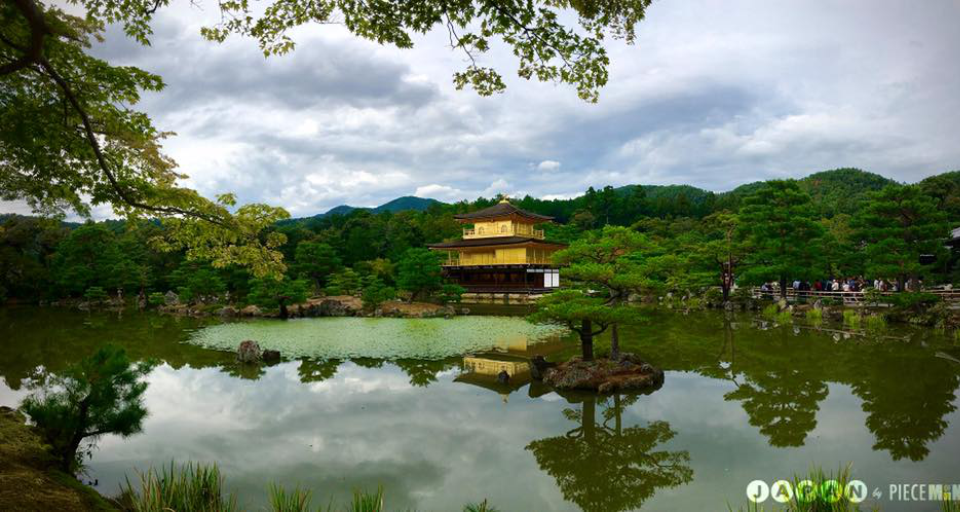

In [ ]:
imshow(content_img, title='Content Image')


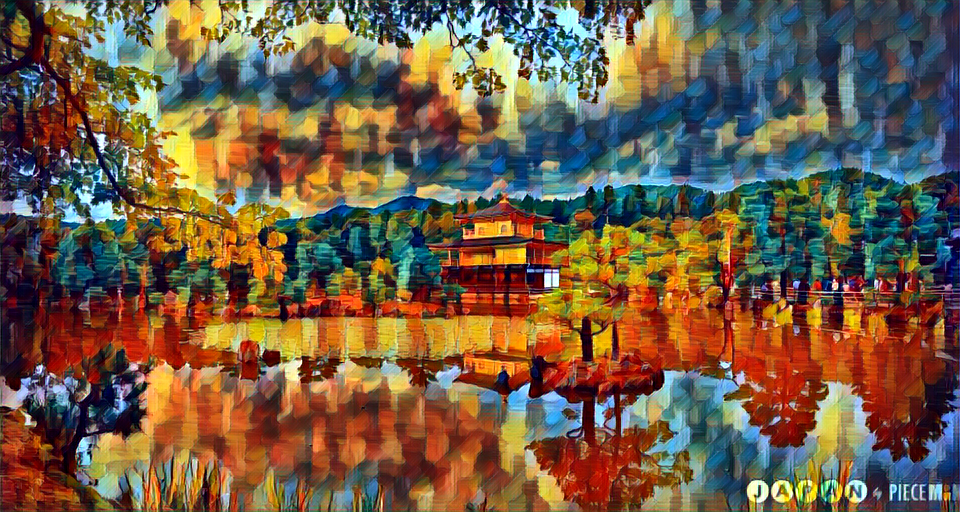

In [ ]:
with torch.no_grad():
  out = style_model(preprocess(content_img))
  out = out.clamp(0,255)
  out = out/255

imshow(out)

## 生成影片吧！(可不做)

In [ ]:
from IPython.display import HTML
HTML(f"""
<h1>我預先把影片上傳到imgur上了，這是rain_princess的結果</h1>
<div>
  <p>用GPU大概花1分鐘</p>
  <p>Total Frames 223</p>
  <p>height 1080</p>
  <p>width 1920</p>
</div>
<video src="https://i.imgur.com/5KzYrxu.mp4" controls autoplay width=100% loop/>
""")

In [ ]:
!pip install pytube

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from pytube import YouTube
yt = YouTube("https://www.youtube.com/watch?v=0tjUqKNf7gU")
video_path = (yt.streams.order_by('resolution').desc().first().download())

In [ ]:
import cv2

In [ ]:
cap = cv2.VideoCapture(video_path)
fps = cap.get(cv2.CAP_PROP_FPS)
num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
print("Total Frames", num_frames)
print("fps", fps)
print("height", h)
print("width", w)

Total Frames 223
fps 23.976023976023978
height 1080
width 1920


In [ ]:
#@title 影片生成
output_path = "out.mp4" #@param {type:"string"}
batch_size = 6 #@param {type:"number"}
frames = []
cap = cv2.VideoCapture(video_path)
out_video_writer = cv2.VideoWriter(
    output_path,
    cv2.VideoWriter_fourcc(*"mp4v"),
    fps,
    (w*2, h)
)
for ith_frame in tqdm(range(num_frames)):
    ret, frame = cap.read()
    frames.append(frame)
    if len(frames) == batch_size or ith_frame+1 == num_frames:
      frames_for_torch = np.array(frames)[..., ::-1] # bgr->rgb
      frames = []
      frames_for_torch = np.einsum("bhwc->bchw",frames_for_torch)
      frames_for_torch = (frames_for_torch/255).astype(np.float32)
      frames_for_torch = torch.from_numpy(frames_for_torch).to(device)

      with torch.no_grad():
        out = style_model(preprocess(frames_for_torch))
        out = out.clamp(0,255)
        out = out/255
      
      to_save = (
          torch.cat((frames_for_torch, out), dim=3)
          .cpu()
          .numpy() * 255
      ).astype(np.uint8)
      to_save = np.einsum(
          "bchw->bhwc", to_save
      )[...,::-1]
      for one_out_frame in to_save:
        out_video_writer.write(one_out_frame)
      # break

out_video_writer.release() 

  0%|          | 0/223 [00:00<?, ?it/s]

### 可以下載並觀看影片(out.mp4)

# 練習
1. 嘗試內差不同模型的參數，比較輸出（已實作）
2. 嘗試修改輸入影像大小，並看看有沒有什麼發現
3. <font color='red'>課後</font>可以嘗試去看看訓練程式碼
> 訓練程式碼的核心與前一份程式碼比起來只需要修改一個部分<br>
把優化的參數，從對`影像`優化改為對`模型參數`優化<br>
https://github.com/pytorch/examples/blob/main/fast_neural_style/neural_style/neural_style.py#L67-L91


## 模型內差
這邊做的事情，是將不同風格模型的權重做內差，看看結果好不好<br>
> 看來節果是不太好的，可以與下一份程式碼的內差結果比較

In [ ]:
model_mix = TransformerNet()
model_mix = model_mix.to(device).eval()

style_model_name_1 = "rain_princess" #@param ['rain_princess', 'udnie', 'mosaic', 'candy']
style_model_name_2 = "udnie" #@param ['rain_princess', 'udnie', 'mosaic', 'candy']

state_1 = get_state_dict(f"./saved_models/{style_model_name_1}.pth")
state_2 = get_state_dict(f"./saved_models/{style_model_name_2}.pth")
def mix_dict(d1,d2, d1_weight):
  assert (
      len(d1.keys()) == len(d2.keys())
  and len(set(d1.keys()) - set(d2.keys())) == 0
  )

  return {
      k : d1[k]*d1_weight + d2[k]*(1-d1_weight)
      for k in d1.keys()
  }

In [ ]:
for weight in np.linspace(0,1,10):
  model_mix.load_state_dict(
      mix_dict(state_1, state_2, weight)
  )

  with torch.no_grad():
    out = model_mix(preprocess(content_img))
    out = out.clamp(0,255)
    out = out/255

  imshow(out,title=f"model 1 weight {weight:0.2f}, model 2 weight {1-weight:0.2f}")

Output hidden; open in https://colab.research.google.com to view.